# Assignment 3: Cross Modal Search [190]

In this assignment, we'll introduce cross-modal search. We'll work with a dataset of images and their corresponding captions, where each image is associated with multiple descriptive captions. Our goal is to learn how to create contextual embeddings for different modalities (images and text) and build an efficient search mechanism that allows us to seamlessly navigate between these modalities. This will enable performing image-to-image, image-to-text, text-to-text, and text-to-image searches.

In [1]:
# !pip -q install datasets
# !pip install einops timm
import io
import warnings
import numpy as np
import hashlib
import torch
from tqdm import tqdm
import heapq
import time
import torch
import pprint
import matplotlib.pyplot as plt
import requests
from PIL import Image
from typing import List, Tuple, Optional, Union, Generator, Dict, Any
from transformers import AutoImageProcessor, AutoModel
from tqdm import tqdm
from torch.utils.data import DataLoader

from pathlib import Path

from transformers import ViTFeatureExtractor

warnings.filterwarnings("ignore")

In [2]:
torch.cuda.is_available()

True

## Dataset Loading and Exploration



Please download the dataset from the following link: [Dataset](https://drive.google.com/file/d/19KPsmsNhj6Q-W6yfYHud2K8EfPdWU2mc/view?usp=sharing).
Once downloaded, you can load and manage the data using the datasets library from Hugging Face.

In [3]:
# load the downloaded dataset from disk here
from datasets import load_from_disk

ds = load_from_disk("task_dataset")

After running this code, you should observe that the dataset contains 15,000 images, each associated with a list of captions. Familiarizing yourself with the dataset structure is essential for the embedding generation and search tasks.

In [4]:
# after loading the dataset, it will look like the following
ds

Dataset({
    features: ['url', 'sentences'],
    num_rows: 15000
})

## Image Embedding Generation [10]

After loading the dataset, the next step is to create meaningful representations of the images in a vector format – image embeddings. These embeddings will capture the semantic essence of the images and enable you to perform similarity comparisons. You have the freedom to choose any embedding method that suits your needs like CNN pretraiend methods or VITs, etc..., but consider its effectiveness for similarity search.
Ensure you embed all images in the dataset using the same chosen method to maintain a comparable embedding space.



---


**Important Note**: It is not allowed to use the same embedding method for image and text, they should be different methods but it's totally fine and recommended if the vector dimensions after embedding of text and image are the same size.

Below find two helper functions to streamline the image loading and embedding process.

In [5]:
processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224", use_fast=True)
model = AutoModel.from_pretrained("google/vit-base-patch16-224").to("cuda")
model.eval()


def load_image_from_url(url: str) -> np.ndarray:
	"""Loads an image from a given URL and converts it to an RGB NumPy array.
  
	Args:
	  url: The URL of the image to load.
  
	Returns:
	  A NumPy array representing the image in RGB format.
	"""
	response = requests.get(url)
	if response.status_code == 200:
		img = Image.open(io.BytesIO(response.content))
		return np.array(img)


def load_image_from_disk(url: str):
	imgs_path = Path("cache")
	filename = hashlib.sha256(url.encode(), usedforsecurity=False).hexdigest() + ".png"
	img = Image.open(imgs_path / filename).convert("RGB")
	return np.array(img)


#TODO redo
def encode_image(batch_imgs):
	"""Encodes a given image URL into an embedding vector.
  
	Args:
	  image:  The URL of the image to encode.
  
	Returns:
	   A NumPy array representing the image embedding.
	"""
	images = [load_image_from_disk(url) for url in batch_imgs['url']]
	inputs = processor(images=images, return_tensors="pt")
	inputs = inputs.to("cuda")
	outputs = model(**inputs).last_hidden_state[:, 0, :]
	return {"embed": outputs.squeeze()}


data = ds.map(encode_image, batched=True, batch_size=64)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

In [141]:
image_data = data['embed']
image_data = [(idx, img) for idx, img in enumerate(image_data)]

## Text Embedding Generation [20]

Similar to what you did when you created embeddings for images, you now need to generate embeddings for the text captions. It's important to consider the multi-caption nature of the data, each image has multiple associated captions, and you should represent this effectively in the text embeddings. Similar to the choice made with image dimension size you should maintain consistency of text dimension embeddign, choosing a good way to embed all captions per image is important to achieve good results.

In [ ]:
!pip install -U sentence_transformers

In [152]:
from sentence_transformers import SentenceTransformer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dimensions = 768
model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1", truncate_dim=dimensions).to(device)


def encode_text(captions: List[List[str]]) -> List[np.ndarray]:
	c = []
	for cap in captions:
		c.append(cap[0])

	captions = c

	embeds = model.encode(captions)
	return embeds


text_data = encode_text(ds['sentences'])

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/114k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [157]:
text_data = [(idx, embed) for idx, embed in enumerate(text_data)]

## Efficient Similarity Search with KD-Trees [70]

One of the main way to implement KNN is based on KD-Tree. KD-Trees are particularly well-suited for nearest neighbor searches in high-dimensional spaces, making them perfect for finding similar images and text based on their embeddings. The KDTree class provided below enables building the tree and performing efficient queries. It allows you to add data in form of tuples, index for image number, caption number inside of images as first parameter and emebdding as second. It also supports euclidean and cosine distance metric based on provided distance type.

**_build_tree**:
This method recursively builds the KDTree. It selects a dimension based on recursion depth, sorts the points along that dimension, and divides the points into subtrees, creating a hierarchical tree structure

**_search_knn**:
This method performs a k-nearest neighbor search by exploring the tree. It keeps track of the closest points and ensures the most relevant candidates are found by searching both subtrees when needed..

**find_knn**:
This method returns the k-nearest neighbors to a target point. It calls the _search_knn method to gather the neighbors and then sorts and returns them, with an option to include their distances.

**nearest_neighbor**:
This method returns the nearest neighbor(s) to a given target point, using the find_knn method. It can return both the points and their distances or just the points, based on the include_distance flag, **this is the method to be used by the user to retireve nearset neighbors.**

__iter__:
This method allows iteration over all points in the KDTree, providing an easy way to loop through the tree’s points in a structured order.


In [231]:
from typing import List, Tuple, Union, Optional, Dict, Any, Generator
import numpy as np
import heapq


class KDTree:
	"""
	A KD-Tree implementation for efficient nearest neighbor search.
	"""

	def __init__(self, points: List[Tuple[int, np.ndarray]], dimension: int, distance_type: str = 'euclidean') -> None:
		"""
		Initializes a new KD-Tree and selects the distance metric.

		Args:
			points: A list of (index, embedding) tuples to build the tree from.
			dimension: The dimensionality of the embedding vectors.
			distance_type: The type of distance metric to use ('euclidean' or 'cosine'). Defaults to 'euclidean'.
		"""
		self.dimension: int = dimension
		self.root: Optional[Dict[str, Union[Tuple[int, np.ndarray], None, None]]] = self._build_tree(points)

		if distance_type == 'euclidean':
			self.distance_func = lambda a, b: np.linalg.norm(a - b)
		elif distance_type == 'cosine':
			self.distance_func = lambda a, b: 1 - np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
		else:
			raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

	def _build_tree(self, points: List[Tuple[int, np.ndarray]], depth: int = 0) -> Optional[Dict[str, Any]]:
		"""
		Recursively builds the KD-Tree from the input points without modifying the input list.
	
		Args:
			points: The set of points to build the tree from.
			depth: The current depth of the recursion, used to determine which dimension to split along.
	
		Returns:
			A node in the tree structure, containing information about the point and its child nodes.
		"""
		if not points:
			return None

		axis = depth % self.dimension
		sorted_points = sorted(points, key=lambda x: x[1][axis])
		median_idx = len(sorted_points) // 2

		return {
			'point': sorted_points[median_idx],
			'left': self._build_tree(sorted_points[:median_idx], depth + 1),
			'right': self._build_tree(sorted_points[median_idx + 1:], depth + 1)
		}

	def insert(self, new_point: Tuple[int, np.ndarray]) -> None:
		"""
		Inserts a new point into the KD-Tree.

		Args:
			new_point: A tuple (index, embedding) to be added to the Tree.
		"""

		def _insert(node, point, depth):
			if node is None:
				return {'point': point, 'left': None, 'right': None}

			axis = depth % self.dimension
			if point[1][axis] < node['point'][1][axis]:
				node['left'] = _insert(node['left'], point, depth + 1)
			else:
				node['right'] = _insert(node['right'], point, depth + 1)
			return node

		self.root = _insert(self.root, new_point, 0)

	def find_knn(self, target: np.ndarray, k: int, include_distances: bool = True) -> List[
		Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]:
		"""
		Finds the k-nearest neighbors to a target point in the KD-Tree.

		Args:
			target: The query embedding.
			k: Number of nearest neighbors to look up.
			include_distances: Whether to return distances between query and neighbors. Default is True.

		Returns:
			List of k-nearest neighbors and optionally distances to those neighbors.
		"""
		max_heap = []
		self._search_knn(self.root, target, k, max_heap)
		result = [(abs(-d), p) for d, p in max_heap]
		result.sort(key=lambda x: x[0])
		return result if include_distances else [r[1] for r in result]

	def _search_knn(self, current_node: Optional[Dict[str, Any]],
					target_point: np.ndarray, k: int,
					max_heap: List[Tuple[float, Tuple[int, np.ndarray]]],
					depth: int = 0) -> None:
		"""
		Recursively searches the KD-Tree for the k-nearest neighbors.

		This method uses a max-heap to efficiently track the k closest points found so far.

		Args:
			current_node: The current node being visited (dictionary with 'point', 'left', 'right').
			target_point: The query point.
			k: The number of nearest neighbors to find.
			max_heap: A max-heap (using heapq) storing (-distance, (index, point)).
			depth: Recursion depth (used for splitting dimension).
		"""
		if current_node is None:
			return

		point, embedding = current_node['point']
		distance = self.distance_func(target_point, embedding)

		if len(max_heap) < k:
			heapq.heappush(max_heap, (-distance, (point, embedding)))
		elif distance < -max_heap[0][0]:
			heapq.heappushpop(max_heap, (-distance, (point, embedding)))

		axis = depth % self.dimension
		diff = target_point[axis] - embedding[axis]
		closer, farther = (current_node['left'], current_node['right']) if diff < 0 else (
			current_node['right'], current_node['left'])

		self._search_knn(closer, target_point, k, max_heap, depth + 1)
		if abs(diff) < -max_heap[0][0] or len(max_heap) < k:
			self._search_knn(farther, target_point, k, max_heap, depth + 1)

	def nearest_neighbor(self, target_point: np.ndarray, k: int = 5, include_distance: bool = True) -> Optional[
		List[Union[Tuple[float, Tuple[int, np.ndarray]], Tuple[int, np.ndarray]]]]:
		"""
		Finds the nearest neighbor to a target point by calling find_knn and returning the result up to k.

		Args:
			target_point: The query embedding.
			k: Number of nearest neighbors to look up.
			include_distances: Whether to return distances. Default is True.

		Returns:
			Optional list of the nearest points and optionally distances.
		"""
		return self.find_knn(target_point, k, include_distance)

	def __iter__(self) -> Generator[Tuple[int, np.ndarray], None, None]:
		"""
		Iterates through all stored embeddings with their indices.

		Returns:
			A generator yielding (index, embedding) tuples.
		"""

		def _traverse(node):
			if node is None:
				return
			yield node['point']
			yield from _traverse(node['left'])
			yield from _traverse(node['right'])

		yield from _traverse(self.root)

	def range_query(self, target: Union[np.ndarray, Tuple[int, np.ndarray]], radius: float) -> List[int]:
		"""
		Finds all points within a certain radius from the target point.

		Args:
			target: The query embedding.
			radius: The maximum allowable distance from the target point.

		Returns:
			A list of indices within the radius.
		"""
		results = []

		def _recursive_search(node, target_embedding, depth=0):
			if node is None:
				return

			point, embedding = node['point']
			distance = self.distance_func(target_embedding, embedding)

			if distance <= radius:
				results.append(point)

			axis = depth % self.dimension
			diff = target_embedding[axis] - embedding[axis]

			_recursive_search(node['left'], target_embedding, depth + 1)
			_recursive_search(node['right'], target_embedding, depth + 1)

		target_embedding = target[1] if isinstance(target, tuple) else target
		_recursive_search(self.root, target_embedding)
		return results


### Testing KD-Tree on Images Data

[]

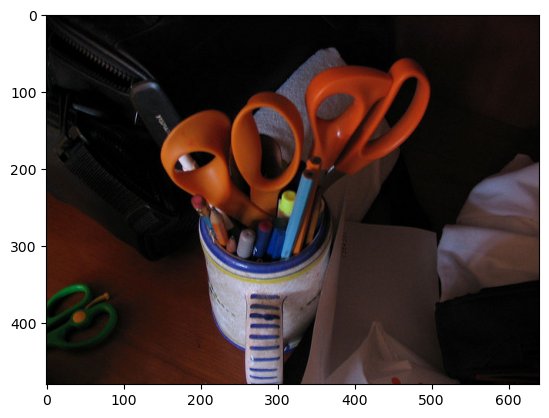

In [242]:
test_point = 110
test_img = load_image_from_url(ds["url"][test_point])
plt.imshow(test_img)
plt.plot()

In [243]:
from copy import deepcopy

start = time.time()
# build the tree
kdtree = KDTree(image_data, dimension=768, distance_type='cosine')
end_build = time.time()

# seache for NN
result = kdtree.nearest_neighbor(image_data[test_point][1], k=6)
end_search = time.time()
print(f"Time to build the KDTree: {end_build - start} seconds")
print(f"Time to build the KDTree and Search: {end_search - start} seconds")

Time to build the KDTree: 0.08922100067138672 seconds
Time to build the KDTree and Search: 0.22494220733642578 seconds


In [244]:
indices = [idx for _, (idx, _) in result] if isinstance(result[0], tuple) else [idx for idx, _ in result]
print("Nearset neighbors indices", indices)

Nearset neighbors indices [4830, 13449, 7440, 3729, 3796, 6534]


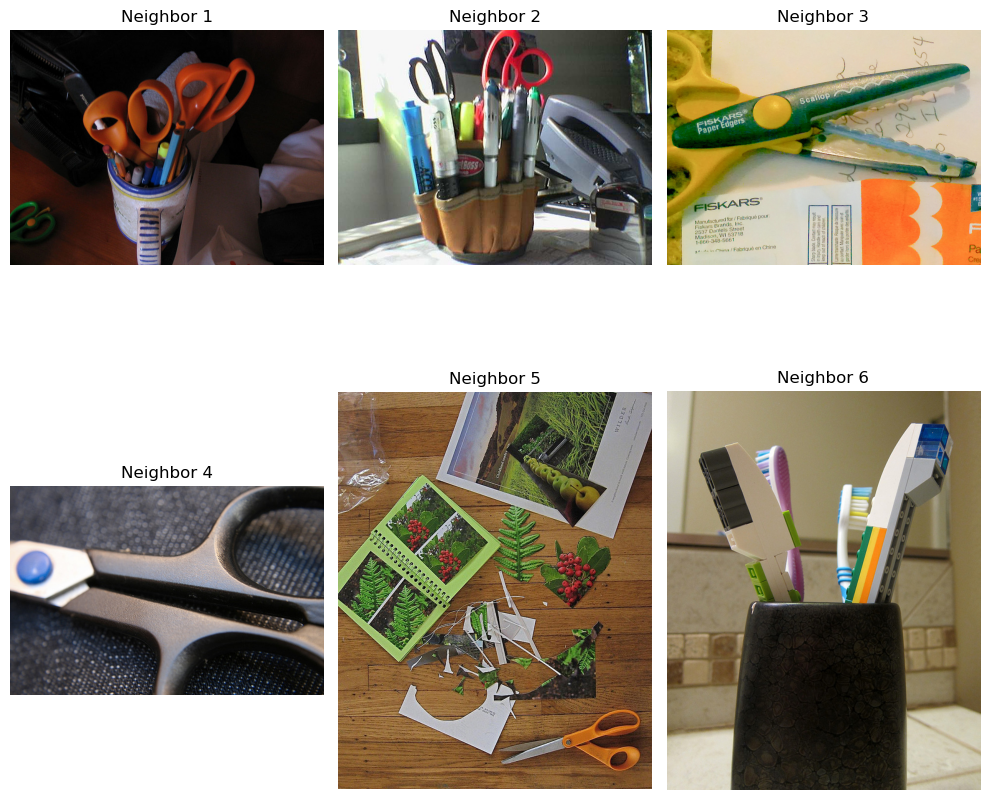

In [245]:
num_neighbors = len(indices)
num_rows = int(num_neighbors ** 0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
	if i < num_neighbors:
		x = load_image_from_url(ds["url"][indices[i]])
		ax.imshow(x)
		ax.set_title(f"Neighbor {i + 1}")
		ax.axis("off")

plt.tight_layout()
plt.show()

### Testing KD-Tree on Text Data

In [154]:
test_point = 110
ds["sentences"][test_point]

['A couple of men standing next to a street sign.',
 'A man in a blue shirt stands on a sidewalk in a large city.',
 'a yellow street sign stating when you can turn on a street',
 'a street sign near a tree with buildings in the bakground',
 'Several street signs shown on a city street.']

In [158]:
start = time.time()
# Build kdtree on text data
kdtree = KDTree(text_data, dimension=768, distance_type='cosine')
end_build = time.time()

# Retrieve the nearest neighbors for a test point
result = kdtree.nearest_neighbor(text_data[test_point][1], k=6)
end_search = time.time()
print(f"Time to build the KDTree: {end_build - start} seconds")
print(f"Time to build the KDTree and Search: {end_search - start} seconds")

Time to build the KDTree: 0.14875483512878418 seconds
Time to build the KDTree and Search: 0.17415165901184082 seconds


In [161]:
indices = [idx for idx, _ in [point for _, point in result]] if isinstance(result[0], tuple) else [idx for idx, _ in
																								   result]
print("Nearset neighbors indices", indices, "\n")

sentences_to_print = [ds["sentences"][i] for i in indices]
pprint.pprint(sentences_to_print, indent=4)

Nearset neighbors indices [110, 4872, 7179, 673, 7743, 9190] 

[   [   'A couple of men standing next to a street sign.',
        'A man in a blue shirt stands on a sidewalk in a large city.',
        'a yellow street sign stating when you can turn on a street',
        'a street sign near a tree with buildings in the bakground',
        'Several street signs shown on a city street.'],
    [   'Two men standing on a street corner in the snow.',
        'A man and a woman walking on a snowy sidewalk.',
        'Man and walker waiting to take a walk in the brisk weather.',
        'civilians at the corner viewing traffic at daytime',
        'A man and a woman both stand in the cold at a stop light'],
    [   'Two workmen posing with a sign concerning the red light they are '
        'near.',
        'Utility workers stand near a traffic light, a sign and an orange and '
        'white traffic cone.',
        'A couple of construction workers standing behind a sign.',
        'Two road c

## Approximate K-Nearest Neighbors with Locality-Sensitive Hashing (LSH) [60]

One effective approach to building an Approximate K-Nearest Neighbor (AKNN) search is by using Locality-Sensitive Hashing (LSH). LSH is a technique that hashes data points in such a way that similar points are more likely to fall into the same hash "bucket." This allows to search a smaller subset of the data for approximate nearest neighbors, making the search process faster, particularly in high-dimensional spaces like embeddings.

Read here: [LSH Paper](https://www.cs.princeton.edu/courses/archive/spring13/cos598C/Gionis.pdf)

> **Note**: LSH operates by reducing dimensional complexity and comparison count, so expect approximate (not exact) results.

The `__init__` method initializes the Locality-Sensitive Hashing (LSH) structure. It prepares the data points, sets up the hash table, and decides which distance metric to use (Euclidean or Cosine).

It sets up the necessary structure for efficiently storing and accessing data points based on similarity, using hash keys generated from random hyperplanes.

---

### `_generate_hyperplanes` Method:
This method generates random hyperplanes used to hash data points into different categories.

It creates the foundation for grouping similar data points together by generating random decision boundaries that will be used to assign points to specific buckets.

---

### `_generate_hash_key` Method:
This method creates a unique identifier (hash key) for each data point based on how the point compares to the generated hyperplanes.

It transforms each data point into a simple identifier (binary key), which helps in quickly finding similar points later by grouping them in the same bucket.

---

### `_query_hash_candidates` Method:
This method looks up potential neighbors of a query point in the hash table by generating multiple hash keys for the query.

It increases the chances of finding similar points by querying the hash table multiple times, ensuring a broader pool of candidates for comparison.

---

### `_create_hash_table` Method:
This method builds a table that associates each data point’s hash key with the points that share the same key.

It organizes the data into buckets based on the hash key, making it easier and faster to find similar points later on.

---

### `approximate_knn_search` Method:
This method performs a quick search to find the nearest neighbors to a query point using the pre-built hash table.

Here’s how the entire pipeline works:

### 1. **Initialization:**
   - When the `LSH` class is initialized, the data points are passed in, and the algorithm sets up essential structures:
     - **Data Storage**: The data points are stored in an array.
     - **Hyperplanes**: Random hyperplanes are generated. These hyperplanes will be used to hash the data points.
     - **Hash Table**: A hash table is created to store data points based on their hash keys.
---

### 2. **Hashing the Data Points:**
   - Every data point is transformed into a unique hash key using the hyperplanes.
   - The method `_generate_hash_key` decide the position of the point with respect to the hyperplane and based on this, a binary string (hash) is created for each point, representing which side of each hyperplane the point lies on.

---

### 3. **Storing Data Points in Buckets:**
   - The hash keys generated for each data point are used to store the points in a hash table.
   - If two data points share the same hash key, they are placed in the same bucket.

---

### 4. **Querying for Nearest Neighbors:**
   - When you query for the nearest neighbors of a point, the algorithm process the query point in the same way as the data points and then
   check it for candidate data points that share the same hash key.

---

### 5. **Candidate Selection and Refinement:**
   - The set of candidate points retrieved from the hash table is not guaranteed to contain the exact nearest neighbors, but they are likely to be similar.
   - The algorithm can query the hash table multiple times (controlled by the `repeat` parameter) to increase the chance of retrieving all relevant candidates.
   - After all candidates are retrived the alog will use distance to refine the retrived points.
---

### Final Flow:
1. **Initialization**: Set up data, hyperplanes, and hash table.
2. **Hashing**: Generate hash keys for each data point and store them in the hash table.
3. **Querying**: For a given query point, generate its hash keys and retrieve candidate points from the hash table.
4. **Refinement and Return**: Calculate distances and Return the top `k` nearest neighbors.

In [296]:
class LSH:
    def __init__(self, index_data: np.ndarray, bucket_size: int = 16, seed: int = 42, distance_type: str = 'cosine', num_tables: int = 10):
        """
        Initialize LSH with data, bucket size, random seed, and distance type.

        :param index_data: Array of tuples where each tuple consists of an index and data point.
        :param bucket_size: Number of data points per bucket.
        :param seed: Seed for random number generator.
        :param distance_type: Type of distance metric, either 'euclidean' or 'cosine'.
        :param num_tables: Number of hash tables to use for repeated searches.
        """
        self.indices, self.data = zip(*index_data)
        self.data = np.asarray(self.data)
        self.bucket_size = bucket_size
        self.rng = np.random.default_rng(seed)
        self.num_tables = num_tables
        self.hyperplanes = [self._generate_hyperplanes() for _ in range(num_tables)]
        self.hash_tables = [self._create_hash_table(i) for i in range(num_tables)]

        if distance_type == 'euclidean':
            self.distance_func = self._euclidean_distance
        elif distance_type == 'cosine':
            self.distance_func = self._cosine_distance
        else:
            raise ValueError("Invalid distance type. Use 'euclidean' or 'cosine'.")

    def _generate_hyperplanes(self) -> np.ndarray:
        """
        Generate random hyperplanes for hashing based on feature dimensions and bucket size.

        :return: Array of hyperplanes for hashing data.
        """
        feature_dim = self.data.shape[1]
        num_hyperplanes = self.bucket_size
        return self.rng.normal(size=(num_hyperplanes, feature_dim))

    def _generate_hash_key(self, points: np.ndarray, hyperplanes: np.ndarray) -> np.ndarray:
        """
        Generate a hash key for given points based on the hyperplanes
        Remember that you need to convert the resulting binary hash into a decimal value.

        :param points: Array of data points to hash.
        :param hyperplanes: Array of hyperplanes to use for hashing.
        :return: Hash keys for the data points.
        """
        binary_hashes = np.dot(points, hyperplanes.T) >= 0
        return binary_hashes.dot(1 << np.arange(binary_hashes.shape[1] - 1, -1, -1))

    def _query_hash_candidates(self, query: np.ndarray, repeat: int = 10) -> List[int]:
        """
        Retrieve candidates from hash table based on query and specified repeat count.

        :param query: Query data point.
        :param repeat: Number of times to hash the query for candidate retrieval.
        :return: List of candidate indices.
        """
        candidates = set()
        for i in range(min(repeat, self.num_tables)):
            hash_key = self._generate_hash_key(query[np.newaxis, :], self.hyperplanes[i])[0]
            if hash_key in self.hash_tables[i]:
                candidates.update(self.hash_tables[i][hash_key])
        return list(candidates)

    def _euclidean_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        return np.linalg.norm(points - query, axis=1)

    def _cosine_distance(self, points: np.ndarray, query: np.ndarray) -> np.ndarray:
        return 1 - np.dot(points, query) / (np.linalg.norm(points, axis=1) * np.linalg.norm(query))

    def _create_hash_table(self, table_index: int) -> dict:
        """
        Create a hash table for the LSH algorithm by mapping data points to hash buckets.

        :param table_index: Index of the hash table to create.
        :return: Hash table with keys as hash values and values as lists of data indices.
        """
        hash_table = {}
        hash_keys = self._generate_hash_key(self.data, self.hyperplanes[table_index])

        for idx, hash_key in enumerate(hash_keys):
            if hash_key not in hash_table:
                hash_table[hash_key] = []
            hash_table[hash_key].append(self.indices[idx])

        return hash_table

    def approximate_knn_search(self, query: np.ndarray, k: int = 5, repeat: int = 10) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Perform approximate K-nearest neighbor search on the query point.

        :param query: Query point for which nearest neighbors are sought.
        :param k: Number of neighbors to retrieve.
        :param repeat: Number of times to hash the query to increase candidate count.
        :return: Tuple of nearest points, their distances, and their original indices.
        """
        candidates_indices = self._query_hash_candidates(query, repeat=repeat)
        if not candidates_indices:
            return np.array([]), np.array([]), np.array([]) 

        candidate_points = self.data[candidates_indices]
        distances = self.distance_func(candidate_points, query)

        nearest_indices = np.argsort(distances)[:k]
        nearest_points = candidate_points[nearest_indices]
        nearest_distances = distances[nearest_indices]
        original_indices = np.array(candidates_indices)[nearest_indices]

        return nearest_points, nearest_distances, original_indices


### Testing LSH on Images Data

In [286]:
test_point = 110
img = load_image_from_url(ds["url"][test_point])
# plt.plot()

In [297]:
start = time.time()
lsh = LSH(image_data)

result = lsh.approximate_knn_search(np.asarray(image_data[test_point][1]), k=6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 6.940050363540649 seconds

Nearest neighbors indices [  110 12302 11107   816 11351  3244]


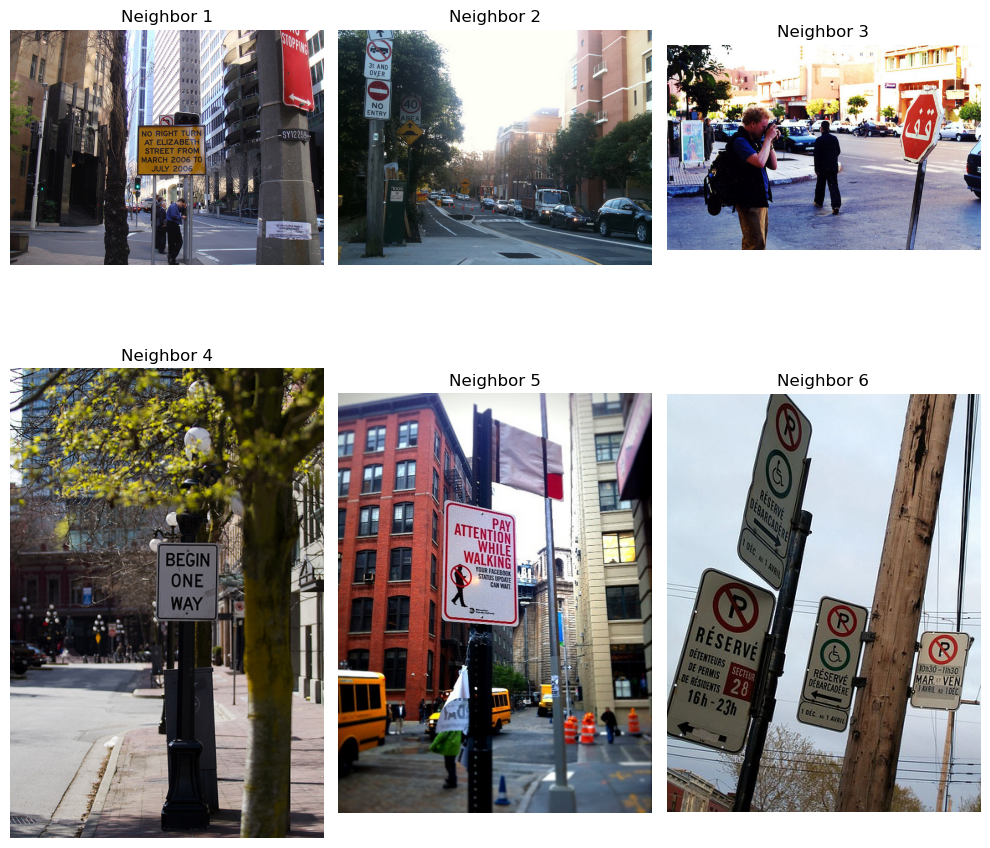

In [298]:
num_neighbors = len(indices)
num_rows = int(num_neighbors ** 0.5)
num_cols = int(np.ceil(num_neighbors / num_rows))

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
	if i < num_neighbors:
		x = load_image_from_url(ds["url"][indices[i]])
		ax.imshow(x)
		ax.set_title(f"Neighbor {i + 1}")
		ax.axis("off")

plt.tight_layout()
plt.show()

### Testing LSH on Text Data

In [291]:
ds["sentences"][test_point]

['A couple of men standing next to a street sign.',
 'A man in a blue shirt stands on a sidewalk in a large city.',
 'a yellow street sign stating when you can turn on a street',
 'a street sign near a tree with buildings in the bakground',
 'Several street signs shown on a city street.']

In [292]:
start = time.time()
lsh = LSH(text_data)
result = lsh.approximate_knn_search(np.asarray(text_data[test_point][1]), k=6)
end_build = time.time()
indices = result[2]
print(f"Time to build and seach in the LSH: {end_build - start} seconds\n")
print("Nearest neighbors indices", indices)

Time to build and seach in the LSH: 5.62072491645813 seconds

Nearest neighbors indices [  110  5543 10066  7743 12532 10862]


In [293]:
sentences_to_print = [ds["sentences"][i] for i in indices]
pprint.pprint(sentences_to_print, indent=4)

[   [   'A couple of men standing next to a street sign.',
        'A man in a blue shirt stands on a sidewalk in a large city.',
        'a yellow street sign stating when you can turn on a street',
        'a street sign near a tree with buildings in the bakground',
        'Several street signs shown on a city street.'],
    [   'Two guys standing with their arms crossed in front of two '
        'motorcycles.',
        'two men stand together with their arms crossed near motorcycles ',
        'Two men standing next to their motorcycles. ',
        'A pair of men in biker wear in front of some motorcycles.',
        'Two biker-type guys trying to look tough standing in front of their '
        'motorcycles. '],
    [   'a couple of signs on a pole by a street',
        'Black and white photo of a street with a sign on a pole.',
        'Black and white photograph of a sign on a city street',
        'some signs cars a street and some trees',
        'A traffic sign is displayed on 

## Cross-Modal Retrieval: Text-to-Image and Image-to-Text Search [30]

Now that you've implemented **image-to-image** and **text-to-text** search, it’s time to expand your capabilities to **cross-modal retrieval**. Cross-modal retrieval allows you to retrieve images when given a text query and vice versa. This section aims to achieve four types of retrieval:

- **Text-to-Text**
- **Image-to-Image**
- **Text-to-Image**
- **Image-to-Text**

**Challenge**: Unlike within-modal searches, cross-modal search involves different embedding spaces—image embeddings and text embeddings—which may not directly correlate with each other. You’ll need to identify a way to align or project both embedding spaces into a common or comparable space.

---

### Suggested Approaches

To achieve cross-modal retrieval, you may consider using one or more of the following methods or any method you want to bring both modalities into alignment:

1. **Canonical Correlation Analysis (CCA)**:
   - CCA is a statistical method designed to find correlations between two sets of variables. It’s often used to project paired data (such as images and their corresponding captions) into a shared space that maximizes correlation.

2. **Multimodal Projection Learning**:
   - Here, you can use supervised or semi-supervised techniques to map both image and text embeddings into a shared subspace. The idea is to minimize the distance between embeddings from each modality that are associated with the same concept (e.g., an image of a “dog” and the caption “a dog playing in the park”).

3. **Partial Least Squares (PLS) Regression**:
   - PLS regression can help project both image and text embeddings into a common latent space, maximizing the covariance between them. This is similar to CCA but it works better for high-dimensional data.

4. **Joint Embedding Optimization**:
   - In this approach, you can train or adjust both text and image embeddings such that paired data points (e.g., an image and its caption) are closer to each other, while non-paired points are farther apart.

5. **Sparse Coding**:
   - This method involves representing both image and text embeddings as sparse codes in a common dictionary space. You can then compute similarities between these sparse representations.

---

### Task Instructions

1. **Method Selection**:
   - Choose an alignment or projection method for cross-modal retrieval from the options above, or research another approach you think might work well.
   - Implement the chosen approach, allowing for text-to-image and image-to-text queries.

2. **Testing and Observations**:
   - Run test queries for **text-to-image**, **image-to-text**, **text-to-text** and **image-to-image** search using your approach.
   - Record your observations:
     - Did the retrieved items was correct?
     - How well does the method capture relationships between the modalities?
     
3. **Code and Results**:
   - Provide the code for your method implementation with results for several test queries.


Below are examples of one solution I created to do searches from text to text, text to image, image to text and image to image.

Imagine we have built KDTree based on text embedding, we insert image query embedding in this tree and search for NN text and when we build KDTree based on images embedding, we insert text query to this tree and search for NN images.

In [ ]:
# text query, this text is not in the dataset, here we are doing text to text
text = "a black dog with white cat"

In [ ]:
# After retriving the top similar NN in text data
print("Indices of top 10 smallest distances:", top_10_indices)

In [ ]:
for i in top_10_indices:
	for j in sentences[i]:
		print(j)
	print("===========")

In [ ]:
# having the same query with the same embedding of this text, here we are searhcing for similar images of this text
# we are doing text-to-images retrival, if we built KDTree on text embedding, we add query image embedding to this tree and search for NN
text = "a black dog with white cat"
print("Indices of top 10 smallest distances:", top_10_indices)

In [ ]:
num_neighbors = len(retrived_image_urls)

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
	if i < num_neighbors:
		x = load_image_from_url(retrived_image_urls[i])
		ax.imshow(x)
		ax.set_title(f"Neighbor {i + 1}")
		ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
# selecting some random image from the dataset, this image also was not part of the dataset, so it's from outside
test_point = ds[14700]["url"]
test_point

In [ ]:
load_image_from_url(test_point)

In [ ]:
# now having our image, we are now doing image to text and below is the closest 10 text to this image
print("Indices of top 10 smallest distances:", top_10_indices)

In [ ]:
for i in top_10_indices:
	for j in ds[i]["sentences"]:
		print(j)
	print("===========")

In [ ]:
# Now we are doing image to image, below is the top 10 closest images to our images
num_neighbors = len(retrived_image_urls)

num_rows = 2
num_cols = 5

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
	if i < num_neighbors:
		x = load_image_from_url(retrived_image_urls[i])
		ax.imshow(x)
		ax.set_title(f"Neighbor {i + 1}")
		ax.axis("off")

plt.tight_layout()
plt.show()

Write you explanation here

In [ ]:
# Write you full code here